# Bellman iteration

Value function of a policy $\pi$

$$ V_{\pi}(s) = \mathbb{E}_{\tau_t\sim p(\tau_t)}[\sum_{i=0}^\infty \gamma^i r_{t+i}|s_t=s]$$

Suppose finite state size and action size, then 

$$ 
\begin{align*}
V_{\pi}(s) &= \mathbb{E}_{a_0, s_{1},...|s_0}[\sum_{i=0}^\infty \gamma^i r_{i}|s_0=s]\\
&= \mathbb{E}_{a_0, s_{1},...|s_0}[r_0 + \gamma\sum_{i=0}^\infty \gamma^i r_{i}|s_0=s]\\
&= \mathbb{E}_{a_0|s_0}\bigg[\mathbb{E}_{s_1|s_0, a_0}\bigg[\mathbb{E}_{a_1, s_2...|s_1}[r_0 + \gamma\sum_{i=0}^\infty \gamma^i r_{i+1}|s_0=s]\bigg]\bigg]\\
&= \sum_{a} \pi(a|s)\sum_{s'} p(s'|s, a) [r_0 +  \gamma \mathbb{E}_{a_1, s_2...|s_1}[\sum_{i=0}^\infty \gamma^i r_{i+1}|s_{1}=s']]\\
&= \sum_{a} \pi(a|s)\sum_{s'} p(s'|s, a) [r_0 +  \gamma V_{\pi}(s')]
\end{align*}
$$

Note that the third line follows from the fact the the distribution we are conditioning is given by 

$$p(\tau_t) = p(s_t=s, a_{t}, r_t, s_{t+1}, a_{t+1},...) = \pi(a_t|s)p(s_{t+1}|s, a_t) p(s_{t+1}, a_{t+1},...)$$

Which we factored out the first two probabilities. The equation $(*)$ is known as the Bellman optimality condition for the value function. We can derive similar results for $Q$-functions. Recall that

$$ 
\begin{align*}
Q_{\pi}(s, a) &= \mathbb{E}_{s_{1}, a_{1},...|s_0, a_0}[\sum_{i=0}^\infty \gamma^i r_{i}|s_0=s, a_0=a]\\
&= \mathbb{E}_{s_{1}, a_{1},...|s_0, a_0}[r_0 + \gamma\sum_{i=0}^\infty \gamma^i r_{i+1}|s_0=s, a_0=a]\\
&= \mathbb{E}_{s_1|s_0, a_0}\bigg[\mathbb{E}_{a_1, s_2,...|s_1}[r_0 + \gamma\sum_{i=0}^\infty \gamma^i r_{i+1}|s_1=s']\bigg]\\
&= \sum_{s'} p(s'|s, a)[r_0 +  \gamma \mathbb{E}_{a_1, s_2,...|s_1}[\sum_{i=0}^\infty \gamma^i r_{i+1}|s_{1}=s']]\\
&= \sum_{s'} p(s'|s, a) [r_0 +  \gamma V_{\pi}(s')]\\
&= \sum_{s'} p(s'|s, a) [r_0 +  \gamma \max_{a'} Q_{\pi}(s', a')]\\
\end{align*}
$$

Now we have a metric for comparing different policies. A policy $\pi$ is better than $\pi'$ on state $s$ if 

$$V_{\pi}(s) \geq V_{\pi'}(s)$$

The optimal policy is defined as 

$$\pi^*(a|s) = \underset{\pi}{\text{argmax}} \; V_{\pi}(s)$$

The optimal policy satisfies the Bellman optimality equation

$$V^*(s) =\max_a\sum_{s'} p(s'|s, a) [r_0 +  \gamma V^*(s')]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GridWorld import *

np.random.seed(0)

In [2]:
def value_iteration(grid_world, max_iter, gamma=0.90):
    height, width = grid_world.height, grid_world.width 
    values = np.zeros((width, height))
    for i in range(max_iter):
        for x in range(width):
            for y in range(height):
                state = (x, y)
                available_actions, successors = grid_world.get_available_actions(state)
                max_value = -float("inf")
                for action in available_actions:
                    value = 0
                    prob_dist = grid_world.get_transition_prob(state, action)
                    for successor, prob in prob_dist.items():
                        reward = grid_world.get_reward(state, successor)
                        value += prob * (reward + gamma * values[successor[0]][successor[1]])
                    max_value = max(max_value, value)
                values[x][y] = max_value
    return values

In [3]:
def extract_q_values(grid_world, values, gamma):
    height, width = grid_world.height, grid_world.width 
    q_values = dict()
    for x in range(width):
        for y in range(height):
            state = (x, y)
            available_actions, successors = grid_world.get_available_actions(state)
            q_value = dict()
            for action in available_actions:
                value = 0
                prob_dist = grid_world.get_transition_prob(state, action)
                for successor, prob in prob_dist.items():
                    reward = grid_world.get_reward(state, successor)
                    value += prob * (reward + gamma * values[successor[0]][successor[1]])
                q_value[action] = value
            q_values[state] = q_value
    return q_values

In [4]:
def extract_policy(q_values):
    policy = dict()
    for state in q_values.keys():
        q_value = q_values[state]
        opt_action = max(q_value, key=q_value.get) if len(q_value) > 0 else None
        policy[state] = opt_action
    return policy

In [5]:
height = 5
width = 5
exits = {'good_exit': (3, 1), 'bad_exit': (3, 2)}
walls = [(1, 2)]
rewards = {'living_reward': -0.1, 'win_reward': 1, 'lose_reward': -1}
init_pos = None

grid_world = GridWorld(height, width, exits, walls, rewards, init_pos, initialize=None)

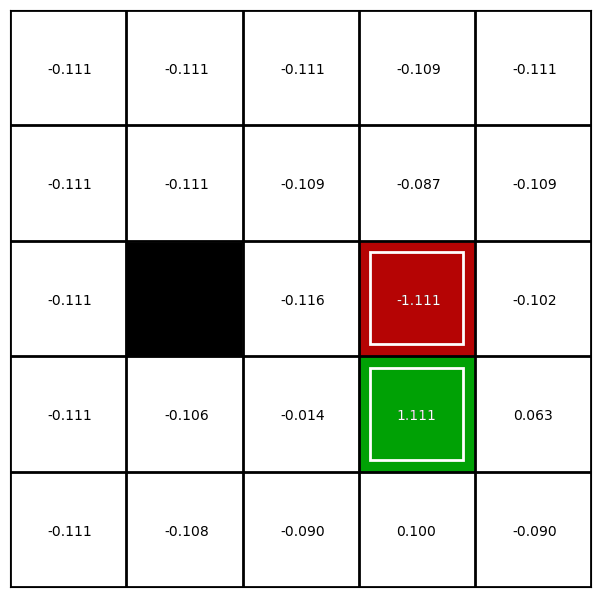

In [6]:
gamma = 0.1
values = value_iteration(grid_world, max_iter=100, gamma=gamma)
display_values(grid_world, values)

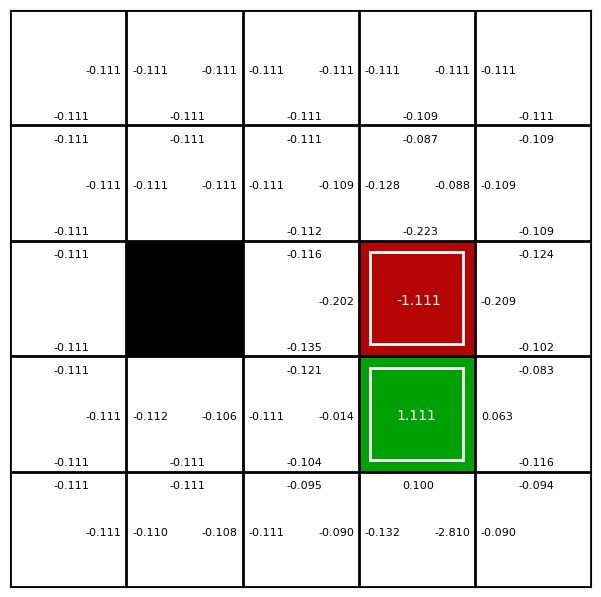

In [7]:
q_values = extract_q_values(grid_world, values, gamma=gamma)
display_qvalues(grid_world, q_values)

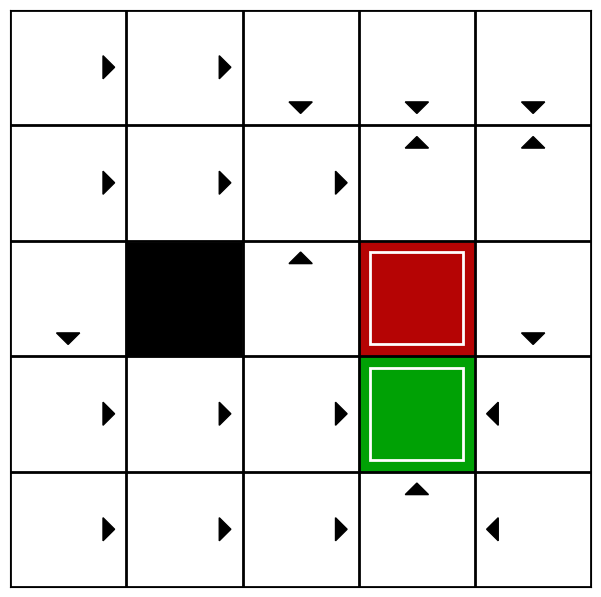

In [8]:
policy = extract_policy(q_values)
display_policy(grid_world, policy)

In the last section, recall that we approximate the value function by the following recursion

$$V_{k+1}(s) = \max_a \sum_{s'} p(s'|s, a)[r_0+\gamma V_{k}(s)]$$

However, it is needed to show that such algorithm indeed converges to the optimal value function $V^*(s)$. To prove convergence, we introduce the Bellman operator $\mathcal{T}:\mathbb{R}^{|\mathcal{S}|}\rightarrow :\mathbb{R}^{|\mathcal{S}|}$. For any $V\in \mathbb{R}^{|\mathcal{S}|}$, define

$$\mathcal{T}V = [\max_a \sum_{s'} p(s'|s, a)[r_0+\gamma V(s)]\;\text{for all}\;s'\in \mathcal{S}]$$

Using this notation, we can compactly rewrite the value iteration update as 

$$V_{k+1} = \mathcal{T}V_k$$

Moreover, it can be observed that 

$$V^* = \mathcal{T}V^*$$

To prove convergence, we first show that $\mathcal{T}$ is a contraction mapping

**Theorem 1**: $\mathcal{T}$ is a contraction mapping under the sup-norm. Given two value function estimates $V, U$, there exists $\gamma\in (0,1)$ such that

$$||\mathcal{T}U-\mathcal{T}V||_{\infty} \leq \gamma||U-V||_{\infty}$$

*Proof:*

$$
\begin{align*}
    ||\mathcal{T}U(s)-\mathcal{T}V(s)||_{\infty} &= \max_s|\max_a \sum_{s'} p(s'|s, a)[r_0+\gamma V(s)] - \max_a \sum_{s'} p(s'|s, a)[r_0+\gamma U(s)]|\\
    &\leq \gamma\max_{s, a} |\sum_{s'} p(s'|s, a) (V(s)-U(s))|\\
    &\leq \gamma \bigg(\sum_{s'} p(s'|s, a)\bigg) \max_s |V(s)-U(s)|\\
    &\leq \gamma||U-V||_{\infty}
\end{align*}
$$

**Theorem 2**: Value iteration converges

$$\lim_{k\to\infty} V_k = V^*$$

*Proof:*

The proof proceeds by noting that $V^*$ is a fixed point of the Bellman operator, and that

$$||V_k-V^*||_{\infty}\leq \gamma ||V_{k-1}-V^*||_{\infty}\leq \cdots \leq \gamma^k||V_0-V^*||_{\infty}$$

Since $\gamma\in (0,1)$, we have that 

$$\lim_{k\to\infty} ||V_k-V^*||_{\infty} = 0\implies \lim_{k\to\infty} V_k = V^*$$